In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn as nn

In [2]:
def generate_data(n_samples):
    """
    Sinusoidal function as defined in D'Angelo et al. 2106.11642
    """
    x = np.concatenate((np.random.uniform(1.5, 2.5, n_samples // 2), np.random.uniform(4.5, 6.0, n_samples - n_samples // 2)))
    y = x * np.sin(x) + np.random.normal(0, 0.25, n_samples)
    return x, y

(-6.0, 4.0)

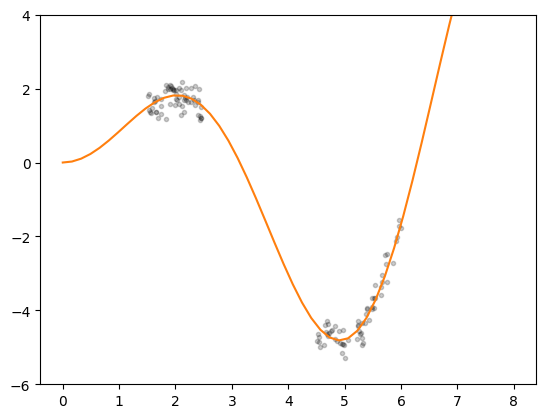

In [3]:
x, y = generate_data(128)
xx = np.linspace(0, 8)
plt.scatter(x, y, marker=".", color="k", alpha=0.2)
plt.plot(xx, xx*np.sin(xx), color="C1")
plt.ylim(-6,4)

(-6.0, 4.0)

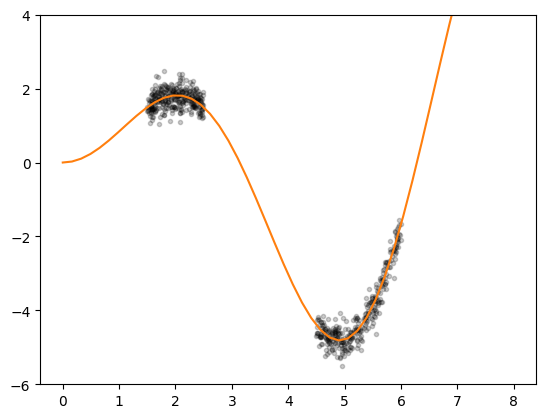

In [4]:
#Or with more data
batch_size = 64
n_samples = batch_size*10

x, y = generate_data(n_samples)
xx = np.linspace(0, 8)
plt.scatter(x, y, marker=".", color="k", alpha=0.2)
plt.plot(xx, xx*np.sin(xx), color="C1")
plt.ylim(-6,4)

In [5]:
class LinearBlock(nn.Module):
  def __init__(self, in_features, out_features, dropout=0.0):
    super().__init__()
    self.linear = nn.Linear(in_features, out_features)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.dropout(self.relu(self.linear(x)))

class GaussianRegressionNet(nn.Module):
    """
    A neural network for regression with a Gaussian likelihood.
    Outputs the mean and log variance of the Gaussian distribution.
    """
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.0):
        super().__init__()

        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
          layers.append(LinearBlock(prev_dim, hidden_dim, dropout_rate))
          prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)

        self.mean_layer = nn.Linear(prev_dim, 1)
        self.log_var_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
      features = self.net(x)
      mean = self.mean_layer(features)
      log_var = self.log_var_layer(features)
      return  mean, log_var

In [6]:
# Define dataset and dataloader
dataset = torch.utils.data.TensorDataset(torch.tensor(x[:,None], dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

def gaussian_nll(mean, log_var, target):
  loss = 0.5 * torch.log(torch.tensor(2 * np.pi)) + log_var + 0.5 * torch.square(mean - target) / torch.exp(log_var)
  return loss

num_epochs = 200
hidden_dims = [64, 64, 64]
input_dim = 1
dropout_rate = 0.1
model = GaussianRegressionNet(input_dim, hidden_dims, dropout_rate)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs*len(loader))

model.train()

for epoch in range(num_epochs):
  for xb, yb in loader:
    optimizer.zero_grad()

    mean, log_var = model(xb)
    loss = gaussian_nll(mean.squeeze(-1), log_var.squeeze(-1), yb).mean()

    loss.backward()
    optimizer.step()
    scheduler.step()


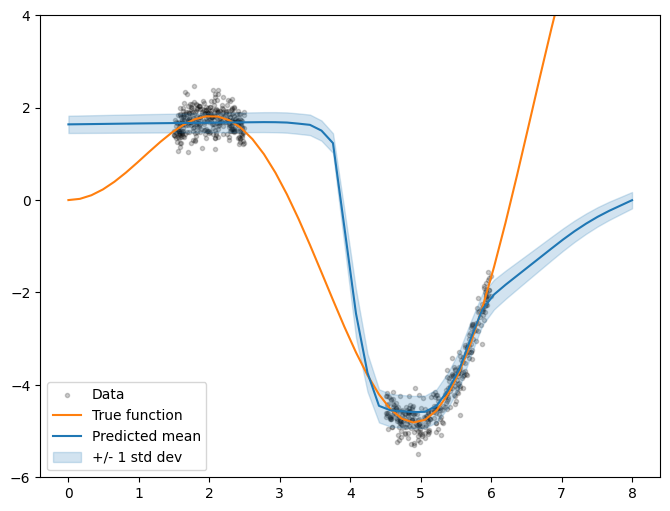

In [7]:
# After training, you can use the model for prediction
model.eval()
with torch.no_grad():
    xx_tensor = torch.tensor(xx, dtype=torch.float32).unsqueeze(1)
    mean_pred, log_var_pred = model(xx_tensor)
    mean_pred = mean_pred.squeeze().numpy()
    var_pred = torch.exp(log_var_pred).squeeze().numpy()
    std_pred = np.sqrt(var_pred)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x, y, marker=".", color="k", alpha=0.2, label='Data')
plt.plot(xx, xx * np.sin(xx), color="C1", label='True function')
plt.plot(xx, mean_pred, color="C0", label='Predicted mean')
plt.fill_between(xx, mean_pred - std_pred, mean_pred + std_pred, color="C0", alpha=0.2, label='+/- 1 std dev')
plt.ylim(-6, 4)
plt.legend()
plt.show()

# MC Dropout

In [8]:
# Extract predictions using dropout at test time
model.train()

n_preds = 50
predictions = []
with torch.no_grad():
  for _ in range(n_preds):
    mean_pred_drop, log_var_drop = model(xx_tensor)
    predictions.append(mean_pred_drop.squeeze().numpy())

predictions = np.array(predictions)
var_pred = torch.exp(log_var_drop).squeeze().numpy()
std_pred = np.sqrt(std_pred)

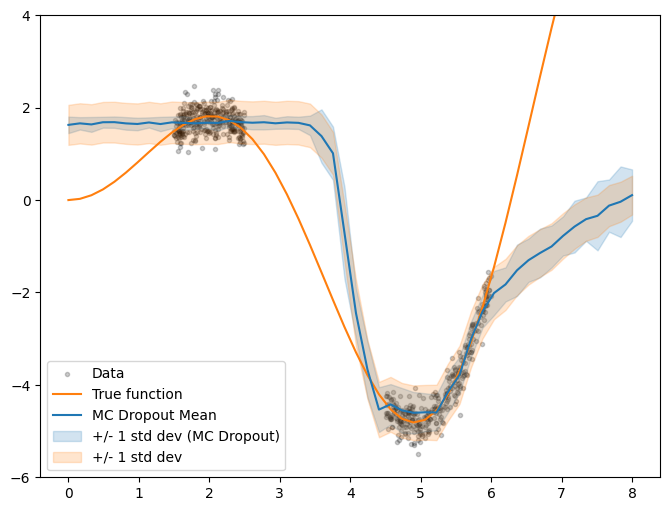

In [9]:
# Calculate mean and standard deviation across the MC dropout predictions
mc_mean = np.mean(predictions, axis=0)
mc_std = np.std(predictions, axis=0)

# Plotting the results with MC Dropout uncertainty
plt.figure(figsize=(8, 6))
plt.scatter(x, y, marker=".", color="k", alpha=0.2, label='Data')
plt.plot(xx, xx * np.sin(xx), color="C1", label='True function')
plt.plot(xx, mc_mean, color="C0", label='MC Dropout Mean')
plt.fill_between(xx, mc_mean - mc_std, mc_mean + mc_std, color="C0", alpha=0.2, label='+/- 1 std dev (MC Dropout)')
plt.fill_between(xx, mc_mean - std_pred, mc_mean + std_pred, color="C1", alpha=0.2, label='+/- 1 std dev')
plt.ylim(-6, 4)
plt.legend()
plt.show()

# Variational Inference

In [67]:
from torch.nn import Parameter
import torch.nn.functional as F

# A simple VBLinear class  similar to nn.Linear
class VBLinear(nn.Module):
    # VB -> Variational Bayes
    def __init__(self, in_features, out_features):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        self.bias = Parameter(torch.Tensor(out_features))
        self.mu_w = Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = Parameter(torch.Tensor(out_features, in_features))
        self.random = torch.randn_like(self.logsig2_w)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()

    def forward(self, x):
      if self.resample:
        self.random = torch.randn_like(self.logsig2_w)
      s2_w = torch.exp(self.logsig2_w)
      weight = self.mu_w + s2_w.sqrt() * self.random
      return nn.functional.linear(x, weight, self.bias)

    def KL(self):
      kl = 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w -1).sum()
      return kl

In [68]:
class VBLinearBlock(nn.Module):
    """A simple linear -> relu -> dropout block."""
    def __init__(self, in_features, out_features, dropout_rate=0.1):
        super().__init__()
        self.linear = VBLinear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.relu(self.linear(x)))

class VBGaussianRegressionNet(nn.Module):
    """
    A neural network for regression with a Gaussian likelihood.
    Outputs the mean and log variance of the Gaussian distribution.
    """
    def __init__(self, input_dim, hidden_dims, training_size, dropout_rate=0.0):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(VBLinearBlock(prev_dim, hidden_dim, dropout_rate))
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)

        # Output layers for mean and log variance
        self.mean_layer = VBLinear(prev_dim, 1)
        self.log_var_layer = VBLinear(prev_dim, 1)

        self.training_size = training_size
        self.vb_layers = []
        for layer in self.net:
          if isinstance(layer, VBLinear):
            self.vb_layers.append(layer)

        self.vb_layers.append(self.mean_layer)
        self.vb_layers.append(self.log_var_layer)


    # we need the KL from the bayesian layers to compute the loss function
    def KL(self):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size

    def reset_parameters(self):
        for layer in self.vb_layers:
                layer.reset_parameters()

    def forward(self, x):
        features = self.net(x)
        mean = self.mean_layer(features)
        log_var = self.log_var_layer(features)
        return mean, log_var

In [69]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Instantiate the model
input_dim = 1
hidden_dims = [128, 128, 128, 128] # Example hidden dimensions
dropout_rate = 0.0 # Example dropout rate

dataset = torch.utils.data.TensorDataset(torch.tensor(x[:,None], dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = VBGaussianRegressionNet(input_dim, hidden_dims, len(dataset), dropout_rate)

# Define optimzer
num_epochs = 1600
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs*len(loader))

# Training loop
model.train()
for epoch in range(num_epochs):
    for xb, yb in loader:

        optimizer.zero_grad()

        mean, log_var = model(xb)
        nll = gaussian_nll(mean.squeeze(-1), log_var.squeeze(), yb).mean()
        kl = model.KL()
        loss = nll + kl

        loss.backward()
        optimizer.step()
        scheduler.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, NLL: {nll.item():.4f}, KL: {kl.item():.4f}')

Epoch [20/1600], Loss: 3.1767, NLL: 1.6035, KL: 1.5732
Epoch [40/1600], Loss: 3.1010, NLL: 1.5502, KL: 1.5508
Epoch [60/1600], Loss: 1.8490, NLL: 0.3177, KL: 1.5313
Epoch [80/1600], Loss: 2.0375, NLL: 0.5249, KL: 1.5126
Epoch [100/1600], Loss: 2.0151, NLL: 0.5222, KL: 1.4928
Epoch [120/1600], Loss: 1.6313, NLL: 0.1589, KL: 1.4725
Epoch [140/1600], Loss: 1.3893, NLL: -0.0626, KL: 1.4519
Epoch [160/1600], Loss: 1.2875, NLL: -0.1432, KL: 1.4307
Epoch [180/1600], Loss: 0.8830, NLL: -0.5264, KL: 1.4094
Epoch [200/1600], Loss: 1.3564, NLL: -0.0317, KL: 1.3881
Epoch [220/1600], Loss: 1.4689, NLL: 0.1020, KL: 1.3669
Epoch [240/1600], Loss: 1.1662, NLL: -0.1793, KL: 1.3456
Epoch [260/1600], Loss: 1.2350, NLL: -0.0895, KL: 1.3245
Epoch [280/1600], Loss: 1.0047, NLL: -0.2986, KL: 1.3034
Epoch [300/1600], Loss: 0.7415, NLL: -0.5405, KL: 1.2820
Epoch [320/1600], Loss: 0.4059, NLL: -0.8549, KL: 1.2608
Epoch [340/1600], Loss: 1.8590, NLL: 0.6194, KL: 1.2396
Epoch [360/1600], Loss: 1.0867, NLL: -0.131

In [70]:
model.eval() # This time in eval mode

n_predictions_vb = 300  # Number of predictions for VB
vb_predictions = []


with torch.no_grad():
    xx_tensor = torch.tensor(xx, dtype=torch.float32).unsqueeze(1)
    for _ in range(n_predictions_vb):
        vb_mean_pred, vb_log_var_pred = model(xx_tensor)
        vb_predictions.append(vb_mean_pred.squeeze().numpy())

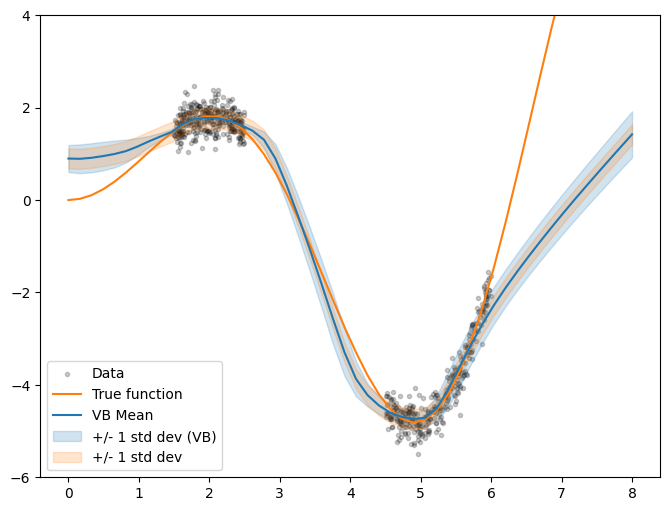

In [71]:
vb_predictions = np.array(vb_predictions)
vb_variance = np.array(torch.exp(vb_log_var_pred.mean(dim=0)))
vb_pred_std = np.sqrt(vb_variance)

# Calculate mean and standard deviation across the VB predictions
vb_mean = np.mean(vb_predictions, axis=0)
vb_std = np.std(vb_predictions, axis=0)

# Plotting the results with VB uncertainty
plt.figure(figsize=(8, 6))
plt.scatter(x, y, marker=".", color="k", alpha=0.2, label='Data')
plt.plot(xx, xx * np.sin(xx), color="C1", label='True function')
plt.plot(xx, vb_mean, color="C0", label='VB Mean')
plt.fill_between(xx, vb_mean - vb_std, vb_mean + vb_std, color="C0", alpha=0.2, label='+/- 1 std dev (VB)')
plt.fill_between(xx, vb_mean - vb_pred_std, vb_mean + vb_pred_std, color="C1", alpha=0.2, label='+/- 1 std dev')
plt.ylim(-6, 4)
plt.legend()
plt.show()

# Deep ensembles

In [49]:
import math

class StackedLinear(nn.Module):
    """
    Efficient implementation of linear layers for ensembles of networks
    """
    def __init__(self, in_features, out_features, channels):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.channels = channels
        self.weight = nn.Parameter(torch.empty((channels, out_features, in_features)))
        self.bias = nn.Parameter(torch.empty((channels, out_features)))
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.channels):
            torch.nn.init.kaiming_uniform_(self.weight[i], a=math.sqrt(5))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight[i])
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            torch.nn.init.uniform_(self.bias[i], -bound, bound)

    def forward(self, input):
        return torch.baddbmm(self.bias[:,None,:], input, self.weight.transpose(1,2))

def kernel(x, y):
    """
    RBF kernel with median estimator
    Motivations for the median estimator heuristic
    https://arxiv.org/pdf/1707.07269
    """
    channels = len(x)
    dnorm2 = (x.reshape(channels,1,-1) - y.reshape(1,channels,-1)).square().sum(dim=2)
    sigma = torch.quantile(dnorm2.detach(), 0.5) / (2 * math.log(channels + 1))
    return torch.exp(- dnorm2 / (2*sigma))

In [50]:
class StackedLinearBlock(nn.Module):
    """A simple linear -> relu -> dropout block."""
    def __init__(self, in_features, out_features, channels, dropout_rate=0.1):
        super().__init__()
        self.linear = StackedLinear(in_features, out_features, channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(self.relu(self.linear(x)))

class StackedGaussianRegressionNet(nn.Module):
    """
    A neural network for regression with a Gaussian likelihood.
    Outputs the mean and log variance of the Gaussian distribution.
    """
    def __init__(self, input_dim, hidden_dims, channels, dropout_rate=0.0):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(StackedLinearBlock(prev_dim, hidden_dim, channels, dropout_rate))
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)

        # Output layers for mean and log variance
        self.mean_layer = StackedLinear(prev_dim, 1, channels)
        self.log_var_layer = StackedLinear(prev_dim, 1, channels)

    def forward(self, x):
        features = self.net(x)
        mean = self.mean_layer(features)
        log_var = self.log_var_layer(features)
        return mean, log_var

In [52]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Instantiate the model
input_dim = 1
hidden_dims = [64, 64, 64, 64] # Example hidden dimensions
dropout_rate = 0.0 # Example dropout rate
channels = 10

dataset = torch.utils.data.TensorDataset(torch.tensor(x[:,None], dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = StackedGaussianRegressionNet(input_dim, hidden_dims, channels, dropout_rate)

# Define optimizer
num_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs*len(loader))

# Training loop
model.train()
for epoch in range(num_epochs):
    for xb, yb in loader:

        optimizer.zero_grad()
        # xb is a vector of shape (64, 1)

        mean, log_var = model(xb.expand(channels, -1, -1)) # (10, 64, 1)
        nll = gaussian_nll(mean.squeeze(-1), log_var.squeeze(-1), yb)

        k = kernel(nll, nll.detach())
        nll_mean = nll.mean(dim=1)
        loss = torch.sum(nll_mean + (k.sum(dim=1)/(k.detach().sum(dim=1))-1)/len(xb), dim=0)

        loss.backward()
        optimizer.step()
        scheduler.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 14.6229
Epoch [20/200], Loss: 4.7535
Epoch [30/200], Loss: -3.2752
Epoch [40/200], Loss: -5.7311
Epoch [50/200], Loss: -5.6538
Epoch [60/200], Loss: -9.9962
Epoch [70/200], Loss: -13.5721
Epoch [80/200], Loss: -13.5412
Epoch [90/200], Loss: -13.6835
Epoch [100/200], Loss: -13.0703
Epoch [110/200], Loss: -14.5900
Epoch [120/200], Loss: -14.9282
Epoch [130/200], Loss: -15.6848
Epoch [140/200], Loss: -15.4960
Epoch [150/200], Loss: -17.2383
Epoch [160/200], Loss: -15.4283
Epoch [170/200], Loss: -16.2606
Epoch [180/200], Loss: -16.6564
Epoch [190/200], Loss: -16.9792
Epoch [200/200], Loss: -16.3326


In [53]:
model.eval()

with torch.no_grad():
  xx_tensor = torch.tensor(xx, dtype=torch.float32).unsqueeze(1)

  # Expand xx_tensor
  xx_exp_tensor = xx_tensor.expand(channels, -1, -1)

  re_mean_pred, re_log_var_pred = model(xx_exp_tensor)
  re_mean_pred = re_mean_pred.squeeze().numpy() # Shape (channels, num_xx)
  re_var_pred = torch.exp(re_log_var_pred).squeeze().numpy()

  # Calculate the overall mean and variance of the predictions
  re_mean = np.mean(re_mean_pred, axis=0)
  re_variance_syst = np.mean(re_var_pred, axis=0)
  re_variance_stat = np.var(re_mean_pred, axis=0)

  re_std_syst = np.sqrt(re_variance_syst)
  re_std_stat = np.sqrt(re_variance_stat)

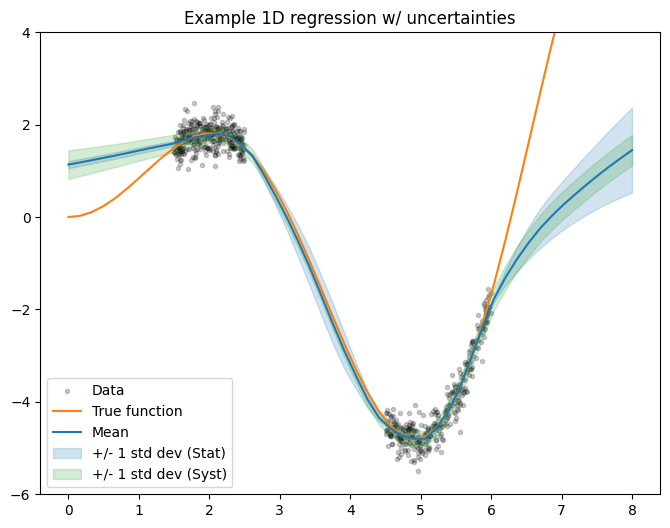

In [54]:
# Plotting the results for StackedGaussianRegressionNet
plt.figure(figsize=(8, 6))
plt.scatter(x, y, marker=".", color="k", alpha=0.2, label='Data')
plt.plot(xx, xx * np.sin(xx), color="C1", label='True function')
plt.plot(xx, re_mean, color="C0", label='Mean')
plt.fill_between(xx, re_mean - re_std_stat, re_mean + re_std_stat, color="C0", alpha=0.2, label='+/- 1 std dev (Stat)')
plt.fill_between(xx, re_mean - re_std_syst, re_mean + re_std_syst, color="C2", alpha=0.2, label='+/- 1 std dev (Syst)')
plt.ylim(-6, 4)
plt.legend()
plt.title("Example 1D regression w/ uncertainties")
plt.savefig("regression_net.pdf", format='pdf')
plt.show()

Food for thought:
- What are the trade-offs in terms of computational cost and performance between these methods?
  - Repulsive ensembles requires parallel or sequential training of multiple neural networks. This can be prohibitive for very large architectures;
  - The Variational Inference presented here introduces a learnable variance for each weight, increasing the number of weights and the iterations needed to converge.
- How would the choice of activation function or network architecture impact the uncertainty estimates?
  - Especially for shallow networks the choice of activation function will change the shape of the learned uncertainties. This will happen in the tail and out of distribution regions, where data cannot constrain the prediction and the model inductive bias is the only factor.
- How does the dropout rate affect the uncertainty estimates? How could you systematically explore different dropout rates?
  - Complex posteriors are difficult to estimate with MC dropout. The choice of the dropout rate should be carried out as part of a grid search where the best neural network is selected according to a validation metric, e.g. the negative log-likelihood.
  In general, posteriors can vary a lot with different dropout rates and other method often produce better estiamtes.
- Why are the variational inference uncertainties unreliable? Can you think of possible solutions to improve the predictive uncertainties?
  - As mentioned above, training with VI requires more iterations. Therefore, we have to make sure that the neural network has converged. Try to train this network for more iterations and make sure that the total loss function has reached a plateau.
- How does the number of models in the ensemble affect the uncertainty estimates?
  - The members of the ensemble converge to samples from the true posterior as $N→+\infty$. Therefore, increasing the number of members will produce better predictions. For very simple examples this can be tested against Hamiltonian Monte Carlo methods. See arXiv:2106.11642 for the predictive uncertainties produced by HMC for this simple 1D dimensional problem.